<a href="https://colab.research.google.com/github/Clarkdrengen/PML_2023/blob/main/pytorch-mnist-VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
"""
Import necessary libraries to create a variational autoencoder
The code is mainly developed using the PyTorch library
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [3]:
"""
Determine if any GPUs are available 
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
# set the current working directory
path = '/content/drive/MyDrive/PML_2023/'
os.chdir(path)

In [6]:
"""
Initialize Hyperparameters
"""
batch_size = 128
learning_rate = 1e-3
num_epochs = 10

In [7]:
"""
Create dataloaders to feed data into the neural network
Default MNIST dataset is used and standard train/test split is performed
"""
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                    transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=1)

In [8]:
"""
A Convolutional Variational Autoencoder
"""
class VAE(nn.Module):
    def __init__(self, imgChannels=1, featureDim=32*20*20, zDim=256):
        super(VAE, self).__init__()
        
        # Initializing the 2 convolutional layers and 2 full-connected layers for the encoder
        self.encConv1 = nn.Conv2d(imgChannels, 16, 5)
        self.encConv2 = nn.Conv2d(16, 32, 5) 
        self.encFC1 = nn.Linear(featureDim, zDim)
        self.encFC2 = nn.Linear(featureDim, zDim)
        
        # Initializing the fully-connected layer and 2 convolutional layers for decoder
        self.decFC1 = nn.Linear(zDim, featureDim)
        self.decConv1 = nn.ConvTranspose2d(32, 16, 5)
        self.decConv2 = nn.ConvTranspose2d(16, imgChannels, 5)
        
    def encoder(self, x):
        
        # Input is fed into 2 convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = F.relu(self.encConv1(x))
        x = F.relu(self.encConv2(x))
        x = x.view(-1, 32*20*20)
        mu = self.encFC1(x)
        logVar = self.encFC2(x)
        return mu, logVar
    
    def reparameterize(self, mu, logVar):
        
        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps
    
    def decoder(self, z):
        
        # z is fed back into a fully-connected layers and then into two transpose convolutional layers
        # The generated output is the same size of the original input
        x = F.relu(self.decFC1(z))
        x = x.view(-1, 32, 20, 20)
        x = F.relu(self.decConv1(x))
        x = torch.sigmoid(self.decConv2(x))
        return x
        
    def forward(self, x):
        
        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encoder(x)
        z = self.reparameterize(mu, logVar)
        out = self.decoder(z)
        return out, mu, logVar
    

In [ ]:
"""
Initialize the network and the Adam optimizer
"""
net = VAE().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

In [ ]:
"""
Training the network for a given number of epochs
The loss after every epoch is printed
"""
for epoch in range(num_epochs):
    for idx, data in enumerate(train_loader, 0):
        imgs, _ = data
        imgs = imgs.to(device)
        
        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out, mu, logVar = net(imgs)
        
        # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
        kl_divergence = -0.5 * torch.sum(1 + logVar - mu.pow(2) - logVar.exp())
        loss = F.binary_cross_entropy(out, imgs, size_average=False) + kl_divergence
        
        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('Epoch {}: Loss {}'.format(epoch, loss))
        

/usr/local/lib/python3.9/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0: Loss 12256.3359375
Epoch 1: Loss 10986.283203125
Epoch 2: Loss 10915.537109375
Epoch 3: Loss 10687.529296875
Epoch 4: Loss 10275.15234375
Epoch 5: Loss 9949.4951171875
Epoch 6: Loss 9972.990234375
Epoch 7: Loss 9955.0498046875
Epoch 8: Loss 10428.9140625
Epoch 9: Loss 9842.19921875


In [ ]:
!ls

data  PML_2023	sample_data


In [11]:
#torch.save(net, '20230415_ConvNet.pt')
net = torch.load(path + '20230415_ConvNet.pt')

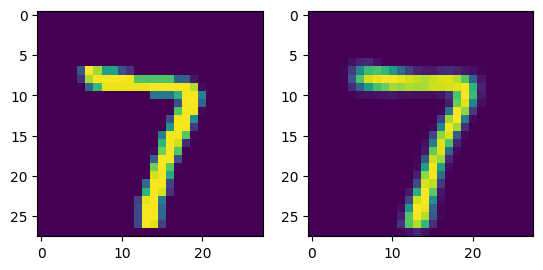

In [12]:
"""
The following part takes a random image from test loader to feed into the VAE.
Both the original image and generated image from the distribution are shown.
"""

import matplotlib.pyplot as plt
import numpy as np
import random

net.eval()
with torch.no_grad():
    for data in random.sample(list(test_loader), 1):
        imgs, _ = data
        imgs = imgs.to(device)
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.subplot(121)
        plt.imshow(np.squeeze(img))
        out, mu, logVAR = net(imgs)
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        plt.subplot(122)
        plt.imshow(np.squeeze(outimg))

## Load generic VAE for comparison

In [13]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [14]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
# Hyper-parameters
image_size = 784
#h_dim = 400
#z_dim = 20
num_epochs = 50
x_dim=784, 
h_dim1= 512, 
h_dim2=256, 
z_dim=2
learning_rate = 1e-3

In [16]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
#vae = VAE(x_dim=image_size , h_dim1= 512, h_dim2=256, z_dim=2)
vae = VAE(x_dim=image_size , h_dim1= 512, h_dim2=256, z_dim=z_dim)
if torch.cuda.is_available():
    vae.cuda()

In [17]:
vae.parameters

<bound method Module.parameters of VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)>

In [18]:
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [19]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        if torch.cuda.is_available():
          data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [20]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            if torch.cuda.is_available():
              data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [ ]:
for epoch in range(1, num_epochs + 1):
    train(epoch)
    test()

Train Epoch: 1 [0/60000 (0%)]	Loss: 545.091016
Train Epoch: 1 [10000/60000 (17%)]	Loss: 190.893789
Train Epoch: 1 [20000/60000 (33%)]	Loss: 167.428906
Train Epoch: 1 [30000/60000 (50%)]	Loss: 171.218184
Train Epoch: 1 [40000/60000 (67%)]	Loss: 168.723809
Train Epoch: 1 [50000/60000 (83%)]	Loss: 161.871689
====> Epoch: 1 Average loss: 178.7854
====> Test set loss: 161.0679
Train Epoch: 2 [0/60000 (0%)]	Loss: 165.337559
Train Epoch: 2 [10000/60000 (17%)]	Loss: 153.766494
Train Epoch: 2 [20000/60000 (33%)]	Loss: 154.633457
Train Epoch: 2 [30000/60000 (50%)]	Loss: 164.140332
Train Epoch: 2 [40000/60000 (67%)]	Loss: 159.095811
Train Epoch: 2 [50000/60000 (83%)]	Loss: 152.961992
====> Epoch: 2 Average loss: 157.8183
====> Test set loss: 154.8225
Train Epoch: 3 [0/60000 (0%)]	Loss: 153.219238
Train Epoch: 3 [10000/60000 (17%)]	Loss: 154.658447
Train Epoch: 3 [20000/60000 (33%)]	Loss: 156.197070
Train Epoch: 3 [30000/60000 (50%)]	Loss: 145.482910
Train Epoch: 3 [40000/60000 (67%)]	Loss: 152.15

In [21]:
#torch.save(vae, '20230415_VAE.pt')
vae = torch.load(path + '20230415_VAE.pt')

In [22]:
# store ground truth test images
test_images_ground_truth, _ = next(iter(test_loader))

Ground truth images reformatted are of dimension torch.Size([12, 1, 28, 28])
Concatenated object containing both ground truth & generic VAE is of size torch.Size([12, 784])
Concatenated object also containing ConvNet VAE is of size torch.Size([36, 1, 28, 28])
torch.Size([12, 1, 28, 28])
torch.cuda.FloatTensor


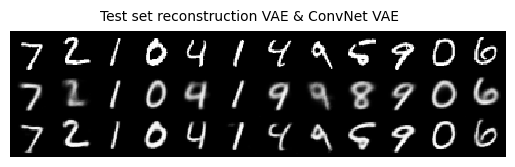

torch.Size([36, 1, 28, 28])


In [23]:
## now create an image of estimated images and ground truth
# h/t https://stackoverflow.com/questions/66667949/pytorch-mnist-autoencoder-to-learn-10-digit-classification

## run first five training images through the encoder
### from https://github.com/dataflowr/notebooks/blob/master/HW3/VAE_clustering_empty.ipynb

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.suptitle('Test set reconstruction VAE & ConvNet VAE', fontsize=10, y=.67)
    plt.axis('off')
    plt.show()

def plot_reconstruction(vae, n=12):
    
    x = test_images_ground_truth
    x = x[:n,:,:,:].to(device)
    print("Ground truth images reformatted are of dimension", x.size())
    try:
        out, _, _, log_p = vae(x.view(-1, image_size)) 
    except:
        out, _, _ = vae(x.view(-1, image_size))
    x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=0)
    print("Concatenated object containing both ground truth & generic VAE is of size", out.size())
    ##
    out, mu, logVAR = net(x)
    
    
    x_concat = torch.cat([x_concat, out.view(-1, 1, 28, 28)], dim=0)
    print("Concatenated object also containing ConvNet VAE is of size", x_concat.size())

    print(out.size())
    print(out.type())
    ##
    out_grid = torchvision.utils.make_grid(x_concat, nrow=12)#.cpu().data
    show(out_grid)
    print(x_concat.size())

plot_reconstruction(vae)

# [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) for MNIST
(J. Ho, A. Jain, P. Abbeel 2020)

![](https://raw.githubusercontent.com/dataflowr/website/master/modules/extras/diffusions/ddpm.png)


Given a schedule $\beta_1<\beta_2<\dots <\beta_T$, the **forward diffusion process** is defined by:
$q(x_t|x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t}x_{t-1},\beta_t I)$ and $q(x_{1:T}|x_0) = \prod_{t=1}^T q(x_t|x_{t-1})$.

With $\alpha_t = 1-\beta_t$ and $\overline{\alpha_t} = \prod_{i=1}^t\alpha_i$, we see that, with $\epsilon\sim\mathcal{N}(0,I)$:
\begin{align*}
x_t = \sqrt{\overline{\alpha}_t}x_0 + \sqrt{1-\overline{\alpha}_t}\epsilon.
\end{align*}
The law $q(x_{t-1}|x_t,\epsilon)$ is explicit: $q(x_{t-1}|x_t,\epsilon) = \mathcal{N}(x_{t-1};\mu(x_t,\epsilon,t), \gamma_t I)$ with,
\begin{align*}
\mu(x_t,\epsilon, t) = \frac{1}{\sqrt{\alpha_t}}\left( x_t-\frac{1-\alpha_t}{\sqrt{1-\overline{\alpha}_t}}\epsilon\right)\text{ and, }
\gamma_t = \frac{1-\overline{\alpha}_{t-1}}{1-\overline{\alpha}_{t}}\beta_t
\end{align*}


**Training**: to approximate **the reversed diffusion** $q(x_{t-1}|x_t)$ by a neural network given by $p_{\theta}(x_{t-1}|x_t) = \mathcal{N}(x_{t-1}; \mu_{\theta}(x_t,t), \beta_t I)$ and $p(x_T) \sim \mathcal{N}(0,I)$, we maximize the usual Variational bound:
\begin{align*}
\mathbb{E}_{q(x_0)} \ln p_{\theta}(x_0) &\geq L_T +\sum_{t=2}^T L_{t-1}+L_0 \text{ with, }L_{t-1} = \mathbb{E}_q\left[ \frac{1}{2\sigma_t^2}\|\mu_\theta(x_t,t) -\mu(x_t,\epsilon,t)\|^2\right].
\end{align*}
With the change of variable:
\begin{align*}
\mu_\theta(x_t,t) = \frac{1}{\sqrt{\alpha_t}}\left( x_t-\frac{1-\alpha_t}{\sqrt{1-\overline{\alpha}_t}}\epsilon_\theta(x_t,t)\right),
\end{align*}
ignoring the prefactor and sampling $\tau$ instead of summing over all $t$, the loss is finally:
\begin{align*}
\ell(\theta) = \mathbb{E}_\tau\mathbb{E}_\epsilon \left[ \|\epsilon - \epsilon_\theta(\sqrt{\overline{\alpha}_\tau}x_0 + \sqrt{1-\overline{\alpha}_\tau}\epsilon, \tau)\|^2\right]
\end{align*}



**Sampling**: to simulate the reversed diffusion with the learned $\epsilon_\theta(x_t,t)$ starting from $x_T\sim \mathcal{N}(0,I)$, iterate for $t=T,\dots, 1$:
\begin{align*}
x_{t-1} = \frac{1}{\sqrt{\alpha_t}}\left( x_t-\frac{1-\alpha_t}{\sqrt{1-\overline{\alpha}_t}}\epsilon_\theta(x_t,t)\right)+\sqrt{\beta_t}\epsilon,\text{ with } \epsilon\sim\mathcal{N}(0,I).
\end{align*}

In [24]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm.notebook import tqdm

In [25]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""
    images = [im.permute(1,2,0).numpy() for im in images]

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx], cmap="gray")
                plt.axis('off')
                idx += 1
    fig.suptitle(title, fontsize=30)
    
    # Showing the figure
    plt.show()

In [26]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.tensor([[i / 10_000 ** (2 * j / d) for j in range(d)] for i in range(n)])
    sin_mask = torch.arange(0, n, 2)

    embedding[sin_mask] = torch.sin(embedding[sin_mask])
    embedding[1 - sin_mask] = torch.cos(embedding[sin_mask])

    return embedding

In [27]:
class MyConv(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(MyConv, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        return out
    
def MyTinyBlock(size, in_c, out_c):
    return nn.Sequential(MyConv((in_c, size, size), in_c, out_c), 
                         MyConv((out_c, size, size), out_c, out_c), 
                         MyConv((out_c, size, size), out_c, out_c))

def MyTinyUp(size, in_c):
    return nn.Sequential(MyConv((in_c, size, size), in_c, in_c//2), 
                         MyConv((in_c//2, size, size), in_c//2, in_c//4), 
                         MyConv((in_c//4, size, size), in_c//4, in_c//4))

In [28]:
class MyTinyUNet(nn.Module):
  # Here is a network with 3 down and 3 up with the tiny block
    def __init__(self, in_c=1, out_c=1, size=32, n_steps=1000, time_emb_dim=100):
        super(MyTinyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = MyTinyBlock(size, in_c, 10)
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)
        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = MyTinyBlock(size//2, 10, 20)
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)
        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = MyTinyBlock(size//4, 20, 40)
        self.down3 = nn.Conv2d(40, 40, 4, 2, 1)

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyConv((40, size//8, size//8), 40, 20),
            MyConv((20, size//8, size//8), 20, 20),
            MyConv((20, size//8, size//8), 20, 40)
        )

        # Second half
        self.up1 = nn.ConvTranspose2d(40, 40, 4, 2, 1)
        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = MyTinyUp(size//4, 80)
        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = MyTinyUp(size//2, 40)
        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = MyTinyBlock(size, 20, 10)
        self.conv_out = nn.Conv2d(10, out_c, 3, 1, 1)

    def forward(self, x, t): # x is (bs, in_c, size, size) t is (bs)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (bs, 10, size/2, size/2)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (bs, 20, size/4, size/4)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (bs, 40, size/8, size/8)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (bs, 40, size/8, size/8)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (bs, 80, size/8, size/8)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (bs, 20, size/8, size/8)
        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (bs, 40, size/4, size/4)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (bs, 10, size/2, size/2)
        out = torch.cat((out1, self.up3(out5)), dim=1)  # (bs, 20, size, size)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (bs, 10, size, size)
        out = self.conv_out(out) # (bs, out_c, size, size)
        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(nn.Linear(dim_in, dim_out), nn.SiLU(), nn.Linear(dim_out, dim_out))

In [29]:
bs = 3
x = torch.randn(bs,1,32,32)
n_steps=1000
timesteps = torch.randint(0, n_steps, (bs,)).long()
unet = MyTinyUNet(in_c =1, out_c =1, size=32)

In [30]:
y = unet(x,timesteps)
y.shape

torch.Size([3, 1, 32, 32])

In [31]:
class DDPM(nn.Module):
    def __init__(self, network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device) -> None:
        super(DDPM, self).__init__()
        self.num_timesteps = num_timesteps
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, dtype=torch.float32).to(device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.network = network
        self.device = device
        self.sqrt_alphas_cumprod = self.alphas_cumprod ** 0.5 # used in add_noise
        self.sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod) ** 0.5 # used in add_noise and step

    def add_noise(self, x_start, x_noise, timesteps):
        # The forward process
        # x_start and x_noise (bs, n_c, w, d)
        # timesteps (bs)
        s1 = self.sqrt_alphas_cumprod[timesteps] # bs
        s2 = self.sqrt_one_minus_alphas_cumprod[timesteps] # bs
        s1 = s1.reshape(-1,1,1,1) # (bs, 1, 1, 1) for broadcasting
        s2 = s2.reshape(-1,1,1,1) # (bs, 1, 1, 1)
        return s1 * x_start + s2 * x_noise

    def reverse(self, x, t):
        # The network return the estimation of the noise we added
        return self.network(x, t)
    
    def step(self, model_output, timestep, sample):
        # one step of sampling
        # timestep (1)
        t = timestep
        coef_epsilon = (1-self.alphas)/self.sqrt_one_minus_alphas_cumprod
        coef_eps_t = coef_epsilon[t].reshape(-1,1,1,1)
        coef_first = 1/self.alphas ** 0.5
        coef_first_t = coef_first[t].reshape(-1,1,1,1)
        pred_prev_sample = coef_first_t*(sample-coef_eps_t*model_output)

        variance = 0
        if t > 0:
            noise = torch.randn_like(model_output).to(self.device)
            variance = ((self.betas[t] ** 0.5) * noise)
            
        pred_prev_sample = pred_prev_sample + variance

        return pred_prev_sample

In [32]:
num_timesteps = 1000
betas = torch.linspace(0.0001, 0.02, num_timesteps, dtype=torch.float32).to(device)

In [33]:
betas[timesteps]

tensor([0.0035, 0.0050, 0.0122], device='cuda:0')

In [34]:
betas[10]

tensor(0.0003, device='cuda:0')

In [35]:
betas[timesteps].reshape(-1,1,1,1).shape

torch.Size([3, 1, 1, 1])

In [36]:
network = MyTinyUNet(in_c =1, out_c =1, size=32)
model = DDPM(network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device)

In [37]:
bs = 5
x = torch.randn(bs,1,32,32).to(device)
timesteps = 10*torch.ones(bs,).long().long().to(device)

In [38]:
timesteps.shape

torch.Size([5])

In [39]:
y = model.add_noise(x,x,timesteps)
y.shape

torch.Size([5, 1, 32, 32])

In [40]:
y = model.step(x,timesteps[0],x)
y.shape

torch.Size([5, 1, 32, 32])

You can check that all the parameters of the UNet network are indeed parameters of the DDPM model like this:

In [41]:
for n, p in model.named_parameters():
    print(n, p.shape)

network.time_embed.weight torch.Size([1000, 100])
network.te1.0.weight torch.Size([1, 100])
network.te1.0.bias torch.Size([1])
network.te1.2.weight torch.Size([1, 1])
network.te1.2.bias torch.Size([1])
network.b1.0.ln.weight torch.Size([1, 32, 32])
network.b1.0.ln.bias torch.Size([1, 32, 32])
network.b1.0.conv1.weight torch.Size([10, 1, 3, 3])
network.b1.0.conv1.bias torch.Size([10])
network.b1.1.ln.weight torch.Size([10, 32, 32])
network.b1.1.ln.bias torch.Size([10, 32, 32])
network.b1.1.conv1.weight torch.Size([10, 10, 3, 3])
network.b1.1.conv1.bias torch.Size([10])
network.b1.2.ln.weight torch.Size([10, 32, 32])
network.b1.2.ln.bias torch.Size([10, 32, 32])
network.b1.2.conv1.weight torch.Size([10, 10, 3, 3])
network.b1.2.conv1.bias torch.Size([10])
network.down1.weight torch.Size([10, 10, 4, 4])
network.down1.bias torch.Size([10])
network.te2.0.weight torch.Size([10, 100])
network.te2.0.bias torch.Size([10])
network.te2.2.weight torch.Size([10, 10])
network.te2.2.bias torch.Size([1

In [42]:
def training_loop(model, dataloader, optimizer, num_epochs, num_timesteps, device=device):
    """Training loop for DDPM"""

    global_step = 0
    losses = []
    
    for epoch in range(num_epochs):
        model.train()
        progress_bar = tqdm(total=len(dataloader))
        progress_bar.set_description(f"Epoch {epoch}")
        for step, batch in enumerate(dataloader):
            batch = batch[0].to(device)
            noise = torch.randn(batch.shape).to(device)
            timesteps = torch.randint(0, num_timesteps, (batch.shape[0],)).long().to(device)

            noisy = model.add_noise(batch, noise, timesteps)
            noise_pred = model.reverse(noisy, timesteps)
            loss = F.mse_loss(noise_pred, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "step": global_step}
            losses.append(loss.detach().item())
            progress_bar.set_postfix(**logs)
            global_step += 1
        
        progress_bar.close()

In [43]:
root_dir = './data/'
transform01 = torchvision.transforms.Compose([
        torchvision.transforms.Resize(32),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5), (0.5))
    ])
dataset = torchvision.datasets.MNIST(root=root_dir, train=True, transform=transform01, download=True)
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=4096, shuffle=True, num_workers=10)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


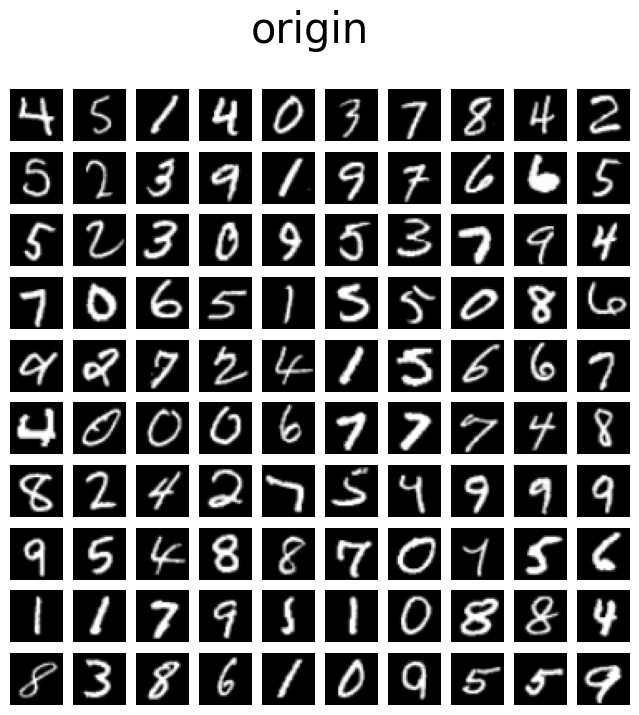

In [44]:
for b in dataloader:
    batch = b[0]
    break

bn = [b for b in batch[:100]] 
show_images(bn, "origin")

In [ ]:
learning_rate = 1e-3
num_epochs = 50
num_timesteps = 1000
network = MyTinyUNet()
network = network.to(device)
model = DDPM(network, num_timesteps, beta_start=0.0001, beta_end=0.02, device=device)
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
training_loop(model, dataloader, optimizer, num_epochs, num_timesteps, device=device)        

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [45]:
#torch.save(model, '20230415_Diffusion.pt')
model = torch.load(path + '20230415_Diffusion.pt')

In [46]:
def generate_image(ddpm, sample_size, channel, size):
    """Generate the image from the Gaussian noise"""

    frames = []
    frames_mid = []
    ddpm.eval()
    with torch.no_grad():
        timesteps = list(range(ddpm.num_timesteps))[::-1]
        sample = torch.randn(sample_size, channel, size, size).to(device)
        
        for i, t in enumerate(tqdm(timesteps)):
            time_tensor = (torch.ones(sample_size,1) * t).long().to(device)
            residual = ddpm.reverse(sample, time_tensor)
            sample = ddpm.step(residual, time_tensor[0], sample)

            if t==500:
                for i in range(sample_size):
                    frames_mid.append(sample[i].detach().cpu())

        for i in range(sample_size):
            frames.append(sample[i].detach().cpu())
    return frames, frames_mid

In [47]:
generated, generated_mid = generate_image(model, 100, 1, 32)

  0%|          | 0/1000 [00:00<?, ?it/s]

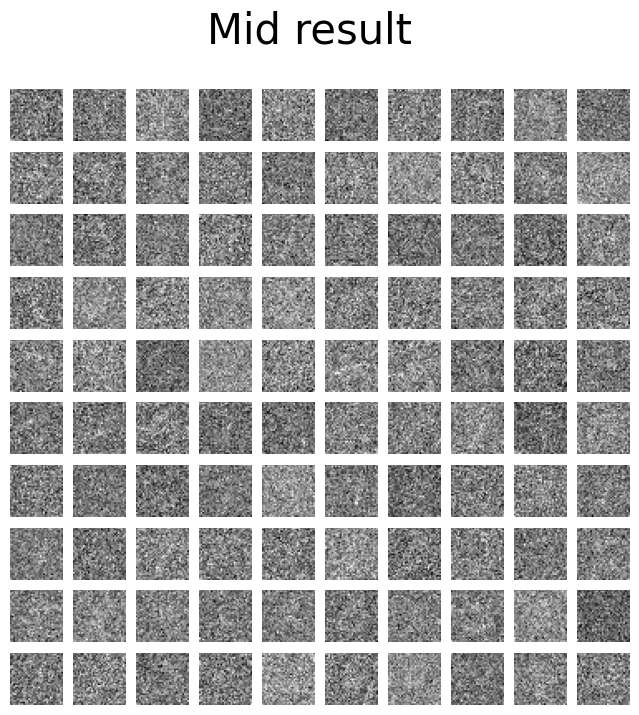

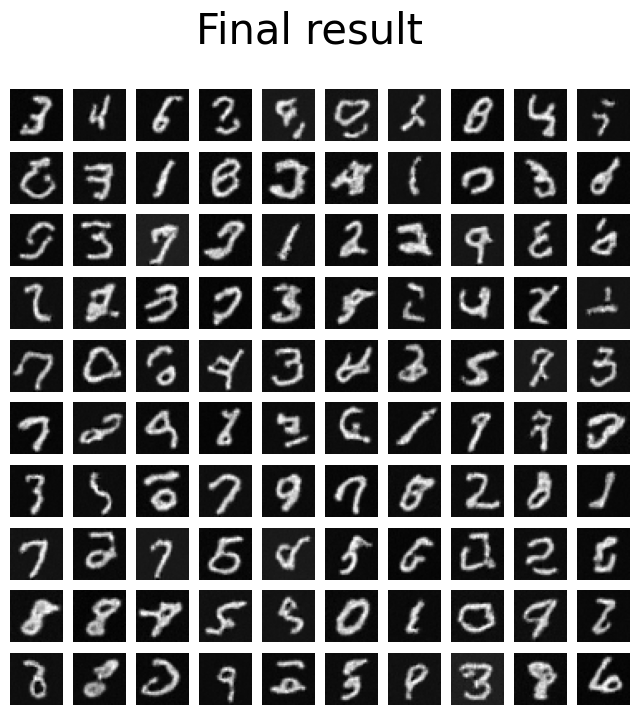

In [48]:
show_images(generated_mid, "Mid result")
show_images(generated, "Final result")

In [49]:
def rescale(x):
    return (x+1)/2

def show_images_rescale(images, title=""):
    """Shows the provided images as sub-pictures in a square"""
    images = [rescale((im.permute(1,2,0)).numpy()) for im in images]

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                #plt.imshow(images[idx].reshape(pixel, pixel, n_channels), cmap="gray")
                plt.imshow(images[idx])
                plt.axis('off')
                idx += 1
    fig.suptitle(title, fontsize=30)
    
    # Showing the figure
    plt.show()

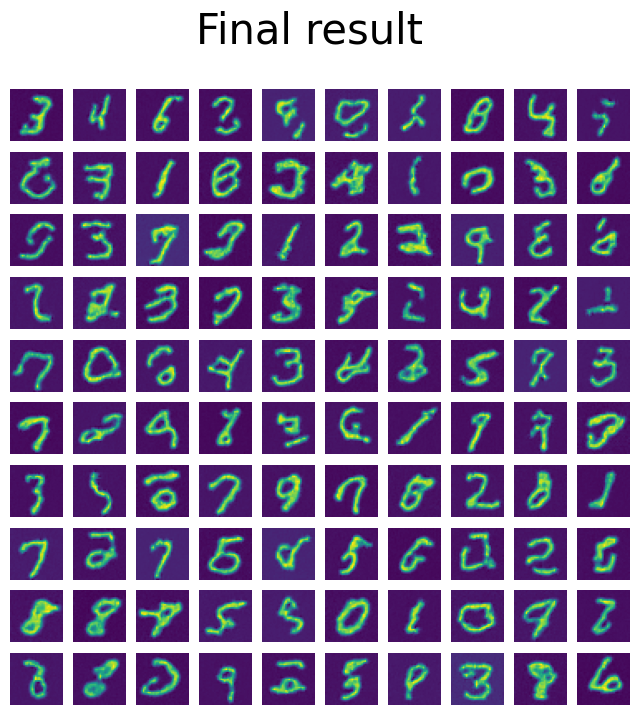

In [50]:
show_images_rescale(generated, "Final result")